# Regresión Lineal
## Datos
Primero vamos a cargar los datos y a importar las librerias que se utilizan.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader, TensorDataset
import random
from tqdm.auto import trange
# tomar n elementos de una secuencia
from itertools import islice as take
import torch.optim as optim

Text(0.5, 0, 'Calificación')

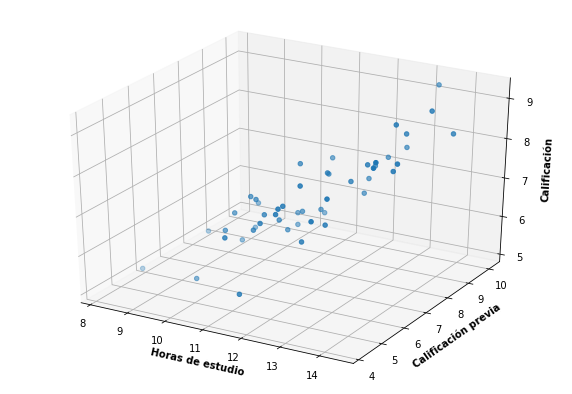

In [ ]:
# datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv'
data_dir = '../data'
filepath = os.path.join(data_dir, 'califs.csv')
df = pd.read_csv(URL)
df.head(5)
random.seed(1)
# Import libraries

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# Create Figure

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")


# Create Plot
#Gráfico en 3D
ax.scatter3D(df['horas'],df['prev'],df['calif'])
ax.set_xlabel('Horas de estudio', fontweight ='bold')
ax.set_ylabel('Calificación previa', fontweight ='bold')
ax.set_zlabel('Calificación', fontweight ='bold')
# Show plot

In [ ]:
# tamaño del lote
BATCH_SIZE = 10

Ahora dividiremos los datos en $80\%$ para entrenamiento y $20\%$ para validación y también se graficarán para revisar los datos. También se transformarán los datos a usar a elementos de Pytorch.

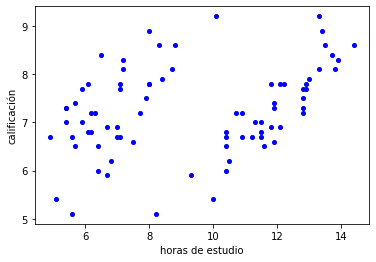

In [ ]:
# se obtiene el atributo de entrada y se agrega una dimensión
X = np.array(df.iloc[:,1], dtype='float32')[..., np.newaxis]
# se obtiene la salda
y= np.array(df.iloc[:,-1], dtype='float32')[..., np.newaxis]
X = np.array(df.iloc[:,:2], dtype="float32")
y = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]
X_ent, X_valid, y_ent, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
plt.plot(X_ent, y_ent, '.', color='b', markersize=8)
plt.xlabel('horas de estudio')
plt.ylabel('calificación')
plt.show()
#Gráfico en 2D
X_ent=torch.tensor(X_ent)
X_valid=torch.tensor(X_valid)
y_ent=torch.tensor(y_ent)
y_valid=torch.tensor(y_valid)

## Modelo de Red Neuronal

### Alto Nivel
Vamos a utilizar primero una interfaz de alto nivel en Pytorch. Al ser una regresión lineal como lo visto en clase se realizará una red neuronal sin capas ocultas con una función de activación lineal como se aprecia mejor en la imágen. 

In [ ]:
def High_Level():
  model=nn.Sequential(
      nn.Linear(2,1),
      #nn.ReLU(),
      #nn.Linear(2,1),
      )
  return model
High_Level()
  

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

### Medio nivel 
En la siguiente linea de código se construye una red neuronal con medio nivel en Pytorch.



In [ ]:
class Medium_Level(nn.Module):

  #Tengo entendido que es como un objeto en Python por lo cual tengo que definir su inicializador, a diferencia del alto nivel que es una función
  def __init__(self):
    #Aquí uso herencia de la clase padre que supongo que es nn.Module
    super().__init__()
    self.Primera = nn.Linear(2,1)
    #self.Segunda = nn.Linear(2, 1)
  #No calculo y_predicha porque mencionaron en clase que era mejor en pasos posteriores con la funcion de activacion
  def forward(self,x):
    x = self.Primera(x)
    #x = F.relu(x)
    #x = self.Segunda(x)
    return x

def constr_Metodo():
  return Medium_Level()
constr_Metodo()

Medium_Level(
  (Primera): Linear(in_features=2, out_features=1, bias=True)
)

## Entrenamiento de los modelos

Para la función de pérdida se utilizará el error cuadrático medio
$
ECM(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{2} \sum_{i = 1} ^n \left(\hat{y^{(i)}} - y^{(i)}\right)^2
$


In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida aquí cambiamos la función de perdida
        loss = F.mse_loss(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)
            #print(y_lgts)
            # computamos los puntajes
            y_pred = y_lgts

            # computamos la clases
            #y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.mse_loss(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()
            
            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=0.0001, epochs=500,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist, model


### Creación de lotes para los modelos

In [ ]:
#Creo mis dataSets para el entrenamiento y la validación
ds = TensorDataset(X_ent, y_ent)
#print(type(y_ent))
def build_dl(batch_size=16, shuffle=True):
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# creamos un DataLoader
train_dl = build_dl()

ds=TensorDataset(X_valid, y_valid)
# creamos un DataLoader
test_dl = build_dl()

### Nivel medio 


In [ ]:
loss_hist, acc_hist, model_medio = train(Medium_Level(), train_dl, test_dl)

  0%|          | 0/500 [00:00<?, ?it/s]

E00 loss=[4247.66,4994.27] acc=[ 0.00, 0.00]
E01 loss=[3467.35,4029.42] acc=[ 0.00, 0.00]
E02 loss=[2805.52,3252.48] acc=[ 0.00, 0.00]
E03 loss=[2080.04,2646.78] acc=[ 0.00, 0.00]
E04 loss=[1788.27,2149.25] acc=[ 0.00, 0.00]
E05 loss=[1401.24,1744.39] acc=[ 0.00, 0.00]
E06 loss=[1140.98,1422.98] acc=[ 0.00, 0.00]
E07 loss=[969.45,1162.96] acc=[ 0.00, 0.00]
E08 loss=[724.83,949.30] acc=[ 0.00, 0.00]
E09 loss=[560.71,788.76] acc=[ 0.00, 0.00]
E10 loss=[486.27,653.51] acc=[ 0.00, 0.00]
E11 loss=[384.04,549.93] acc=[ 0.00, 0.00]
E12 loss=[302.89,463.12] acc=[ 0.00, 0.00]
E13 loss=[279.78,390.84] acc=[ 0.00, 0.00]
E14 loss=[231.43,332.12] acc=[ 0.00, 0.00]
E15 loss=[207.39,280.96] acc=[ 0.00, 0.00]
E16 loss=[168.11,246.26] acc=[ 0.00, 0.00]
E17 loss=[139.54,216.13] acc=[ 0.00, 0.00]
E18 loss=[119.92,190.37] acc=[ 0.00, 0.00]
E19 loss=[113.38,169.15] acc=[ 0.00, 0.00]
E20 loss=[100.50,153.72] acc=[ 0.00, 0.00]
E21 loss=[ 90.56,139.14] acc=[ 0.00, 0.00]
E22 loss=[ 89.69,126.71] acc=[ 0.00, 0.

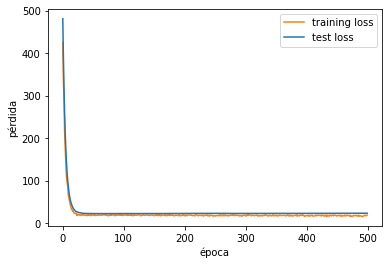

In [ ]:
#print(len(y_ent))
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss,'tab:orange', label='training loss')
plt.plot(tst_loss,'tab:blue', label='test loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

### Alto Nivel

In [ ]:
loss_hist, acc_hist, model_alto = train(High_Level(), train_dl, test_dl)

  0%|          | 0/500 [00:00<?, ?it/s]

E00 loss=[2340.17,2570.27] acc=[ 0.00, 0.00]
E01 loss=[1854.43,2047.40] acc=[ 0.00, 0.00]
E02 loss=[1469.22,1641.45] acc=[ 0.00, 0.00]
E03 loss=[1176.46,1307.54] acc=[ 0.00, 0.00]
E04 loss=[915.72,1047.41] acc=[ 0.00, 0.00]
E05 loss=[751.06,839.52] acc=[ 0.00, 0.00]
E06 loss=[592.75,674.09] acc=[ 0.00, 0.00]
E07 loss=[475.93,542.36] acc=[ 0.00, 0.00]
E08 loss=[383.89,437.77] acc=[ 0.00, 0.00]
E09 loss=[306.17,353.92] acc=[ 0.00, 0.00]
E10 loss=[246.84,287.35] acc=[ 0.00, 0.00]
E11 loss=[195.23,234.80] acc=[ 0.00, 0.00]
E12 loss=[165.01,192.75] acc=[ 0.00, 0.00]
E13 loss=[128.72,160.61] acc=[ 0.00, 0.00]
E14 loss=[104.44,135.29] acc=[ 0.00, 0.00]
E15 loss=[ 88.17,112.25] acc=[ 0.00, 0.00]
E16 loss=[ 69.43, 95.18] acc=[ 0.00, 0.00]
E17 loss=[ 65.44, 82.47] acc=[ 0.00, 0.00]
E18 loss=[ 57.30, 71.75] acc=[ 0.00, 0.00]
E19 loss=[ 45.43, 63.56] acc=[ 0.00, 0.00]
E20 loss=[ 38.98, 55.99] acc=[ 0.00, 0.00]
E21 loss=[ 41.90, 50.71] acc=[ 0.00, 0.00]
E22 loss=[ 35.78, 45.89] acc=[ 0.00, 0.00]
E2

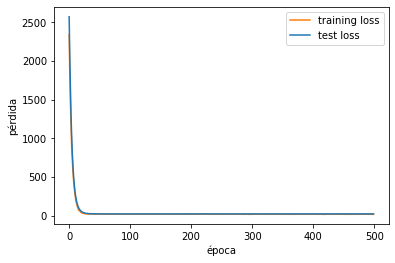

In [ ]:
#print(len(y_ent))
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss,'tab:orange', label='training loss')
plt.plot(tst_loss,'tab:blue', label='test loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

## Cálculos utilizando el modelo ya entrenado
Aquí me encontré con un problema, la solución propuesta es a la hora de entrenar los modelos regresar el modelo y guardarlo en una variable y se solucionó el problema. A la hora de correr el código comentado presenta problemas me gustaría discutir esta problematica en clase y preguntar porque pasa: mi hipotesis es que algo tiene que ver el entrenamiento, ya que las definiciones de la arquitectura las comparé con unos compañeros al no encontrar respuestas del error en internety eran idénticas sólo cambiaba el nombre de las variables empleadas. 

In [ ]:
#High_Level(torch.tensor([4.0,12.0])))
resultado1=model_medio(torch.tensor([3.0,12.0]))
resultado2=model_alto(torch.tensor([3.0,12.0]))
print("Calificación módelo con interfaz media=", float(resultado1))
print("Calificación módelo con interfaz alta=", float(resultado2))


Calificación módelo con interfaz media= 5.959846496582031
Calificación módelo con interfaz alta= 5.849603176116943


In [ ]:
X=torch.tensor(X)
y=[]
for x in X:
  y_pred = float(model_alto(x))
  y.append(y_pred)
#print(len(y))
yalto = np.array(y)

Text(0.5, 0, 'Calificación')

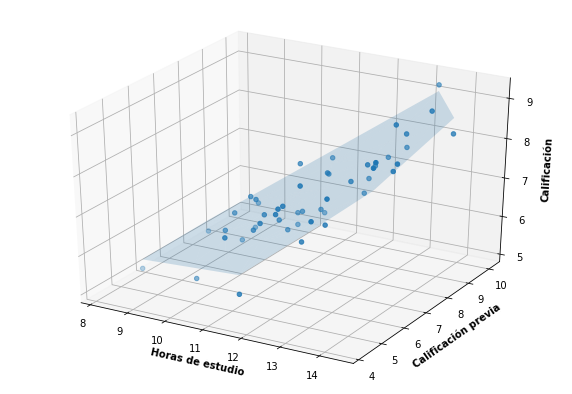

In [ ]:
# Create Figure

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")


# Create Plot
#Gráfico en 3D
ax.scatter3D(df['horas'],df['prev'],df['calif'])
ax.plot_trisurf(df['horas'],df['prev'],yalto,alpha=0.2)
ax.set_xlabel('Horas de estudio', fontweight ='bold')
ax.set_ylabel('Calificación previa', fontweight ='bold')
ax.set_zlabel('Calificación', fontweight ='bold')
# Show plot

In [ ]:
X=torch.tensor(X)
y=[]
for x in X:
  y_pred = float(model_medio(x))
  y.append(y_pred)
#print(len(y))
ymedio = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Calificación')

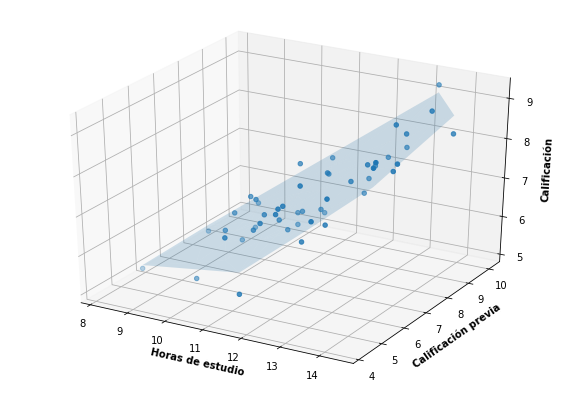

In [ ]:
# Create Figure

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")


# Create Plot
#Gráfico en 3D
ax.scatter3D(df['horas'],df['prev'],df['calif'])
ax.plot_trisurf(df['horas'],df['prev'],ymedio, alpha=0.2)
ax.set_xlabel('Horas de estudio', fontweight ='bold')
ax.set_ylabel('Calificación previa', fontweight ='bold')
ax.set_zlabel('Calificación', fontweight ='bold')
# Show plot

## Conclusiones

Hay que recordar la ecuación de una recta:
$$
Y= mx+b.
$$
Sin embargo al tener dos entradas esta ecuación cambia a:
$$
Y = m_1x_1+m_2x_2+b. 
$$
Lo cual es un plano por eso las gráficas anteriores. Para los valores de $\alpha = 0.1$ el código se rompe y no se puede realizar los cálculos, también las épocas fueron cambiadas de 20 a 500 y eso mejora un poco las perdidas pero como no se tiene la métrica de accuracy se utilizó el ejemplo pedido como tarea de un estudiante que obtuvo un 3 de calificación en el examen pasado y ahora va a estudiar 12 horas. Ya que por lógica al usar 20 épocas los resultados eran bastante malos como por ejemplo un 8.14 de calificación. Finalmente creo que sería de importancia ver el error que mencioné antes y porque mi correción que para mi es burda lo solucionó. 